Para abrir este notebooks  to Google Colab clicar aqui <a href="https://github.com/vnikoofard/Econofisica/blob/main/4-Topicos%20em%20Econofisica/Analise%20de%20Series%20temporais%20usando%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Introdução**

O uso de Redes Neurais Convolucionais tornou-se a abordagem de ponta em várias tarefas de reconhecimento de imagem, visão computacional e reconhecimento de fala. Isso se deve ao seu sucesso em resolver problemas complexos graças à sua capacidade de extrair informações relevantes de estruturas de dados semelhantes a imagens a partir de certas suposições de invariância de localização e compartilhamento de pesos (Veja o Módulo 2 deste curso).

Nos próximos dois módulos deste curso, descreveremos os principais modelos de Deep Learning que são usados em problemas de previsão de séries temporais (Redes Neurais Recorrentes entre outras arquiteturas). Mas antes de descrever esses conceitos, vale mencionar que existem metodologias úteis que nos permitem transformar informações de séries temporais em imagens. Essas versões em imagem das séries temporais podem então ser usadas como entradas para CNNs que nos permitem prever os rótulos associados a cada série temporal.

Transformar séries temporais em imagens pode ser mais eficaz do que recorrer a modelos de séries temporais de Deep Learning por duas razões. Primeiro, as CNNs geralmente têm um comportamento melhor durante o treinamento. Segundo, podemos explorar arquiteturas complexas de CNN pré-treinadas, que não estão prontamente disponíveis para arquiteturas explícitas de séries temporais.

In this notebook, we implement the Gramian Angular Field (GAF) methodology that we described in Lesson 3, and illustrate its outcome for a general financial time series. In the previous Lesson, we showed a straightforward coding implementation in Python for GAF. In this notebook, we are going to make use of the "pyts" library, which we load below and that includes a readily available class that performs the GAF transformation.

In [2]:
import matplotlib.pyplot as plt

try:
    from pyts.image import GramianAngularField
except ImportError:
    !%pip install pyts
    from pyts.image import GramianAngularField

Primeiro, mostramos para um conjunto de dados de código aberto, [GunPoint](http://timeseriesclassification.com/description.php?Dataset=GunPoint), como o GAF realiza as transformações de séries temporais. As informações deste conjunto de dados, criado para tarefas de visão computacional, fornecem informações sobre a localização das mãos de um ator em uma sequência onde o ator saca uma arma (ou finge sacar uma arma). As imagens são representadas de uma visão lateral. Por favor, siga o link anterior se estiver interessado em aprender mais sobre este conjunto de dados.

Quando carregamos o conjunto de dados, obtemos uma matriz bidimensional onde, das 50 linhas, cada linha contém informações de uma série temporal com 150 observações. Cada série temporal é "contígua" à outra, deslocando um período de tempo as observações da sequência anterior. Isso significa que a segunda linha contém a mesma série temporal que a primeira linha, exceto pelas primeiras e últimas observações. A primeira observação na segunda linha é a segunda observação da primeira linha, a segunda observação na segunda linha é a terceira observação da primeira linha e assim por diante...

Formalmente, considere uma série temporal com realizações $\{x_1, x_2,...,x_K\}$. Podemos dividir a série temporal em sequências de $T$ observações $\{x_t, x_{t+1}, x_{t+2},...,x_{t+T}\}$, para $t\in[1,K-T]$. Então, formamos a matriz $X$ que empilha cada uma dessas sequências:

$$
X = \begin{pmatrix}
    x_1 & x_2 & \cdots & x_T \\
    x_2 & x_3 & \cdots & x_{T+1} \\
    x_3 & x_4 & \cdots & x_{T+2} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{K-T} & x_{K-T+1} & \cdots & x_{K}  
    \end{pmatrix}
$$

In [3]:
from pyts.datasets import load_gunpoint

X, _, _, _ = load_gunpoint(return_X_y=True)
# Check the shape of the array
print(X.shape)
# Print the first 10 observations of the first two rows
# Check that both sequences are contiguous to each other
print(X[0, 0:10])
print(X[0, 1:11])

(50, 150)
[-0.6478854  -0.64199155 -0.63818632 -0.63825875 -0.63834515 -0.63869741
 -0.64304876 -0.64376789 -0.64504991 -0.64711823]
[-0.64199155 -0.63818632 -0.63825875 -0.63834515 -0.63869741 -0.64304876
 -0.64376789 -0.64504991 -0.64711823 -0.64915334]


Agora transformamos cada série temporal usando o Gramian Angular Field. Lembre-se de que a transformação envolve, primeiro, uma transformação Min-Max de cada série temporal que reescala a informação para o intervalo [-1,1]. Em segundo lugar, calculamos as coordenadas polares, principalmente o termo $\phi_t=\arccos{(\widetilde{x}_t)}$, para cada observação da série temporal escalada. Finalmente, construímos a matriz do tipo Gram, para cada série temporal:

$$
    G = \begin{pmatrix}
           \cos{(\phi_1 + \phi_1)} & \cos{(\phi_1 + \phi_2)} &  \cdots & \cos{(\phi_1 + \phi_T)}  \\
           \cos{(\phi_2 + \phi_1)} & \cos{(\phi_2 + \phi_2)} &  \cdots & \cos{(\phi_2 + \phi_T)} \\
           \vdots & \vdots & \ddots & \vdots \\
           \cos{(\phi_T + \phi_1)} & \cos{(\phi_T + \phi_2)} &  \cdots & \cos{(\phi_T + \phi_T)} \\
        \end{pmatrix}
$$

(150, 150)
(150, 150)


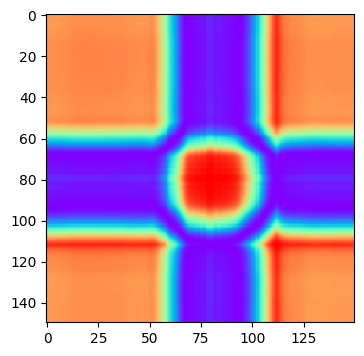

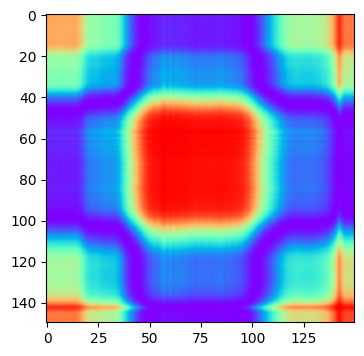

In [4]:
transformer = GramianAngularField()
X_new = transformer.transform(X)
# Show the results for the first time series
plt.figure(figsize=(4, 4))
plt.imshow(X_new[0], cmap="rainbow")
print(X_new[0].shape)
# Show the results for the 10th time series
plt.figure(figsize=(4, 4))
plt.imshow(X_new[9], cmap="rainbow")
print(X_new[9].shape)

A versão em imagem do conjunto de dados pode então ser usada para treinar uma rede neural convolucional projetada para aprender a partir de uma imagem se uma pessoa, vista de lado, está sacando uma arma ou não.

## **3. GAF PARA UMA SÉRIE TEMPORAL FINANCEIRA**

Agora, vamos realizar a mesma tarefa para uma série temporal financeira. Vamos usar informações diárias sobre o preço de fechamento do ETF QQQ que acompanha o índice Nasdaq. Utilizaremos mais de 20 anos de informações.

In [53]:
import numpy as np
import yfinance as yf

df = yf.download("PETR4.SA", start="2010-01-01", end="2024-10-11")
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2024-10-04 00:00:00+00:00,37.840000,37.840000,38.200001,37.669998,38.150002,22526800
2024-10-07 00:00:00+00:00,38.369999,38.369999,38.380001,37.900002,38.040001,36418000
2024-10-08 00:00:00+00:00,37.599998,37.599998,37.750000,37.450001,37.470001,34142000
2024-10-09 00:00:00+00:00,37.220001,37.220001,37.520000,37.009998,37.369999,30789800
2024-10-10 00:00:00+00:00,37.650002,37.650002,37.740002,37.320000,37.400002,20630100


(3671,)


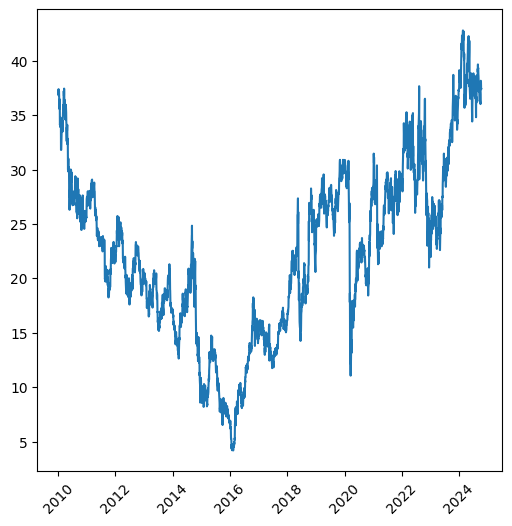

In [54]:
Xdf = df.iloc[:, 4]
print(Xdf.shape)
plt.figure(figsize=(6, 6))
plt.xticks(rotation=45)
plt.plot(Xdf)
plt.show()

Agora construímos a matriz $X$ que definimos acima para os novos dados, empilhando séries temporais de 30 observações. Ilustramos na figura abaixo como $X$ representa informações sobre 5.781 séries temporais de 30 observações em intervalos sobrepostos, conforme descrito acima.

(3636, 35)


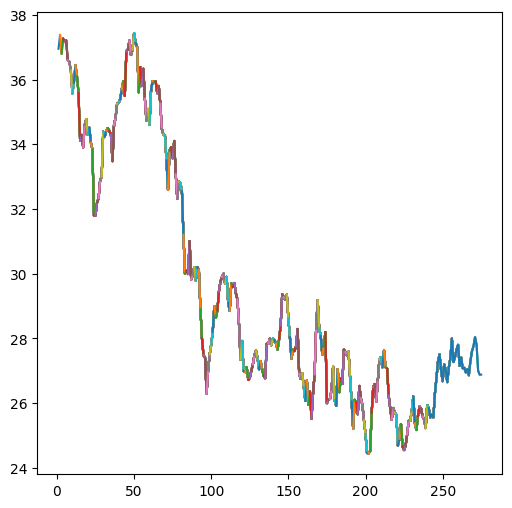

In [55]:
X_train = []
window_size = 35
for i in range(window_size, Xdf.shape[0]):
    X_train.append(Xdf[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

Em seguida, aplicamos a transformação GAF e ilustramos os resultados para algumas observações. Note como a transformação atribui valores próximos de zero para aquelas observações que estão próximas da média da série temporal, enquanto atribui valores altos para aquelas realizações que são relativamente mais "extremas" dentro de cada série temporal.

Agora temos uma amostra de 5.781 imagens, às quais podemos anexar um rótulo, por exemplo, se o preço subiu ou desceu nos dias seguintes, e treinar uma Rede Neural Convolucional usando os procedimentos que descrevemos no Módulo 2 e nas duas primeiras lições do Módulo 3.

In [56]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(3636, 35, 35)


(35, 35)


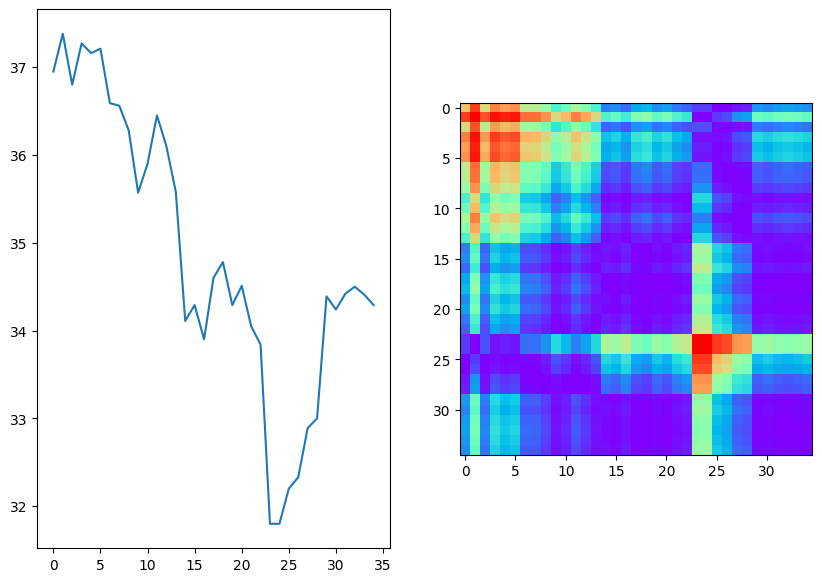

In [57]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train[0, :])
ax[1].imshow(X_train_new[0], cmap="rainbow")
print(X_train_new[0].shape)

(35, 35)


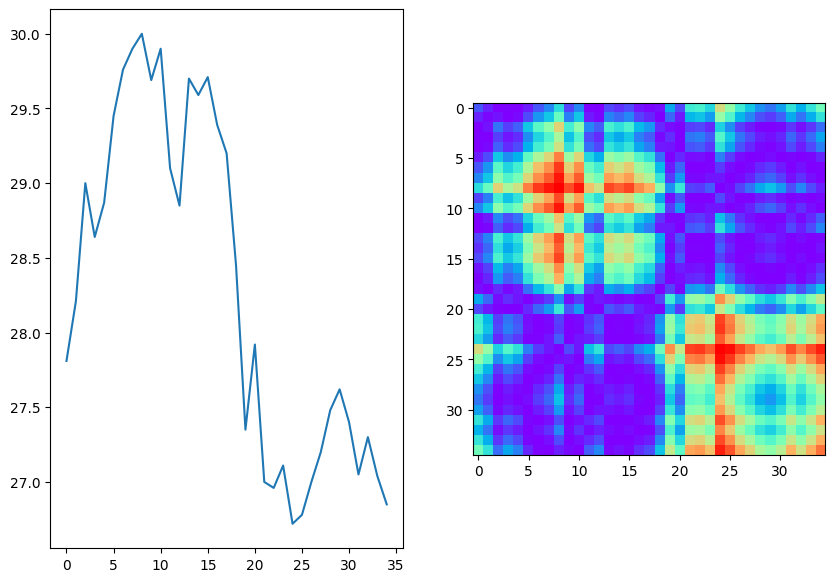

In [58]:
# Show the results for the 100th time series
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train[99, :])
ax[1].imshow(X_train_new[99], cmap="rainbow")
print(X_train_new[99].shape)

## **3. USANDO A SÉRIE TRANSFORMADA EM UMA CNN**

Nos blocos de código abaixo, projetamos uma rede neural convolucional para prever a evolução da série temporal. A esta altura, você já deve estar familiarizado com esse tipo de estrutura, então deixamos a análise da arquitetura da rede e seu desempenho para o seu próprio julgamento.

In [59]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, Xdf.shape[0] - window_size):
    y_data.append(Xdf.iloc[i] < Xdf.iloc[i + window_size])
y_data = np.array(y_data)
y_data.shape

(3601,)

In [61]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(3601, 35, 35)

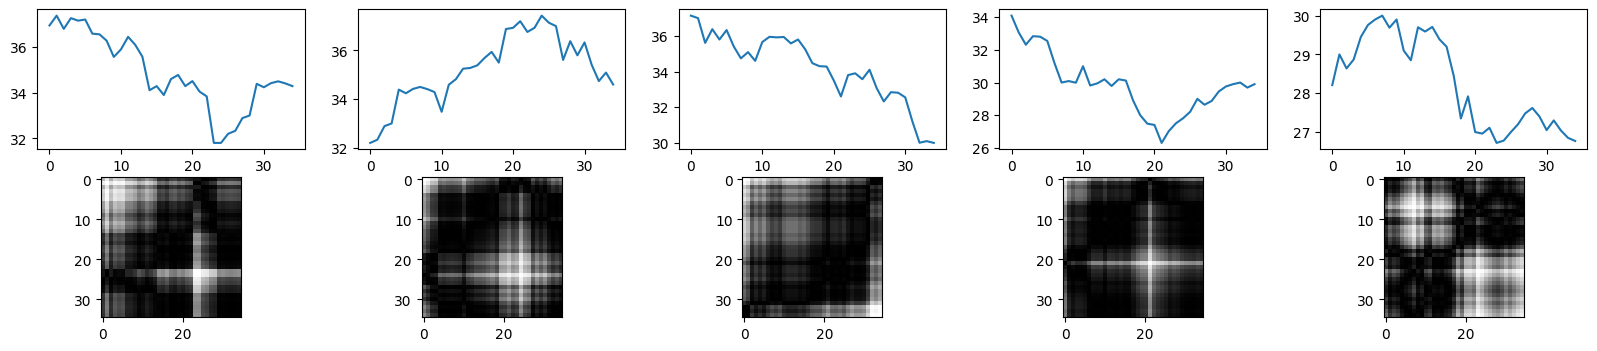

In [62]:
# display several time series and the corresponding images
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(0, 125, 25):
    ax[0, int(i / 25)].plot(X_train[i])
for i in range(0, 125, 25):
    ax[1, int(i / 25)].imshow(X_data[i], "gray")

In [63]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [80]:
X_data_train[0].shape

(35, 35)

In [ ]:
print(X_data_train.shape)
print(X_data_test.shape)

(2880, 35, 35)
(721, 35, 35)


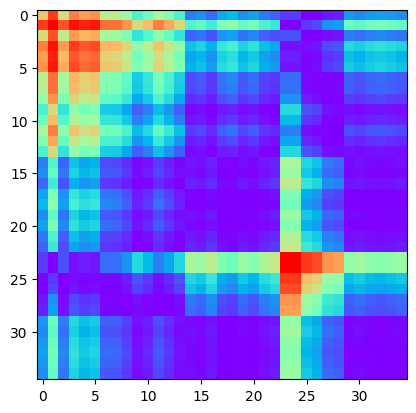

In [68]:
plt.imshow(X_data_train[0], cmap="rainbow")
plt.show()

In [69]:
# create a dataloader for training and testing

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # nomralize the data
        X = (X - np.min(X)) / (np.max(X) - np.min(X))
        X = X.reshape(-1, 1, window_size, window_size)
        self.X = torch.tensor(X).float().to(device)
        self.y = torch.tensor(y).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


BATCH_SIZE = 32

train_dataset = TimeSeriesDataset(X_data_train, y_data_train)
test_dataset = TimeSeriesDataset(X_data_test, y_data_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# vamos usar estes numeros mais adiante para calcular a acuracia
test_N = len(test_loader.dataset)
train_N = len(train_loader.dataset)



So verificando os tamanhos

In [70]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 35, 35])

In [71]:
kernel_size = 3
flattened_img_size = 75 * 4 * 4
n_classes = 1

model = nn.Sequential(
    # First convolution
    nn.Conv2d(1, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 4 x 4
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Sigmoid()
)


model = model.to(device)

In [72]:
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=1200, out_features=512, bias=True)
    (15): Dropou

In [73]:
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

pos_weight = torch.tensor([class_weight[0]], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=0.001)



{0: 2.0556745182012848, 1: 1.0}


In [74]:
def get_batch_accuracy(output, y, N):
    pred = (output > 0.5).float()
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [75]:
def validate(model, data_loader, loss_fn, N):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x).squeeze()

            loss += loss_fn(output, y).item()
            accuracy += get_batch_accuracy(output, y, test_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [76]:
def train(model, data_loader, loss_fn, N):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x).squeeze()
        optimizer.zero_grad()
        batch_loss = loss_fn(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, len(train_loader.dataset))
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

    # Step the scheduler

In [77]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(model, train_loader, loss_fn, train_N)
    validate(model, test_loader, loss_fn, test_N)

Epoch: 0
Train - Loss: 87.2863 Accuracy: 0.5118
Valid - Loss: 20.8996 Accuracy: 0.6061
Epoch: 1
Train - Loss: 87.3283 Accuracy: 0.5128
Valid - Loss: 20.9356 Accuracy: 0.6061
Epoch: 2
Train - Loss: 87.2578 Accuracy: 0.5135
Valid - Loss: 20.9248 Accuracy: 0.6061
Epoch: 3
Train - Loss: 87.1195 Accuracy: 0.5142
Valid - Loss: 20.9406 Accuracy: 0.6061
Epoch: 4
Train - Loss: 86.4179 Accuracy: 0.5271
Valid - Loss: 21.9063 Accuracy: 0.5631
Epoch: 5
Train - Loss: 85.5394 Accuracy: 0.5517
Valid - Loss: 22.7387 Accuracy: 0.5257
Epoch: 6
Train - Loss: 85.2907 Accuracy: 0.5601
Valid - Loss: 21.1240 Accuracy: 0.6019
Epoch: 7
Train - Loss: 83.9823 Accuracy: 0.5833
Valid - Loss: 22.2270 Accuracy: 0.5617
Epoch: 8
Train - Loss: 85.0744 Accuracy: 0.5753
Valid - Loss: 24.5465 Accuracy: 0.4341
Epoch: 9
Train - Loss: 85.1060 Accuracy: 0.5625
Valid - Loss: 21.6201 Accuracy: 0.5687
Epoch: 10
Train - Loss: 84.6295 Accuracy: 0.5691
Valid - Loss: 21.9830 Accuracy: 0.5728
Epoch: 11
Train - Loss: 83.8802 Accuracy: 

In [78]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x).squeeze()
        predicted = (outputs > 0.5).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print("Accuracy over validation: {:.2f}%".format(accuracy * 100))

Accuracy over validation: 56.03%


              precision    recall  f1-score   support

       False       0.26      0.06      0.10       284
        True       0.59      0.88      0.71       437

    accuracy                           0.56       721
   macro avg       0.43      0.47      0.41       721
weighted avg       0.46      0.56      0.47       721



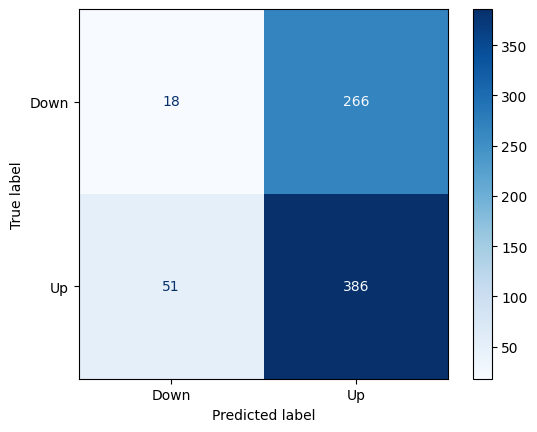

In [79]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_prob = []
model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        outputs = model(x).squeeze()
        y_prob.extend(outputs.cpu().numpy())

y_prob = np.array(y_prob)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_data_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_data_test, y_pred))

# **4. TRANSFER LEARNING**

In [82]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

In [83]:
# Freeze base model
vgg_model.requires_grad_(False)
next(iter(vgg_model.parameters())).requires_grad

False

In [92]:
n_classes = 1


my_model = nn.Sequential(
    vgg_model.features,
    vgg_model.avgpool,
    nn.Flatten(),
    vgg_model.classifier[0:3],
    nn.Linear(4096, 500),
    nn.ReLU(),
    nn.Linear(500, n_classes),
    nn.Sigmoid()
)

my_model = my_model.to(device)

my_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [93]:
optimizer = Adam(my_model.parameters())
my_model = torch.compile(my_model.to(device))

In [94]:
from torchvision.transforms import v2
from PIL import Image

# Define the transform for grayscale images to RGB
transform = v2.Compose([
    #v2.ToImage(),  # Convert tensor to PIL Image
    v2.Grayscale(num_output_channels=3),  # Replicate channel to make it RGB
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True), #v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for VGG16
])


# create a dataloader for training and testing

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # nomralize the data
        X = (X - np.min(X)) / (np.max(X) - np.min(X))
        X = X.reshape(-1, 1, window_size, window_size)
        self.X = torch.tensor(X).float().to(device)
        self.y = torch.tensor(y).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        img = transform(img)  # Apply the transform
        return img, self.y[idx]


BATCH_SIZE = 32

train_dataset = TimeSeriesDataset(X_data_train, y_data_train)
test_dataset = TimeSeriesDataset(X_data_test, y_data_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# vamos usar estes numeros mais adiante para calcular a acuracia
test_N = len(test_loader.dataset)
train_N = len(train_loader.dataset)


In [95]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [96]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, train_loader, loss_fn, train_N)
    validate(my_model, test_loader, loss_fn, test_N)

Epoch: 0
Train - Loss: 87.4160 Accuracy: 0.5108
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 1
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 2
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 3
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 4
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 5
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 6
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 7
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 8
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 9
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 10
Train - Loss: 87.2595 Accuracy: 0.5135
Valid - Loss: 20.9357 Accuracy: 0.6061
Epoch: 11
Train - Loss: 87.2595 Accuracy: 

In [97]:
y_prob

array([9.99988198e-01, 9.99771655e-01, 9.99272048e-01, 4.87014800e-01,
       8.52836311e-01, 9.79971409e-01, 9.99697924e-01, 4.32538331e-01,
       9.98375058e-01, 9.99999762e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.99802649e-01, 1.00000000e+00,
       9.99999285e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.99970794e-01, 9.99997139e-01, 9.99951839e-01,
       1.00000000e+00, 9.99579370e-01, 1.00000000e+00, 9.99918461e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       284
        True       0.61      1.00      0.75       437

    accuracy                           0.61       721
   macro avg       0.30      0.50      0.38       721
weighted avg       0.37      0.61      0.46       721



/home/vahid/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vahid/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vahid/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


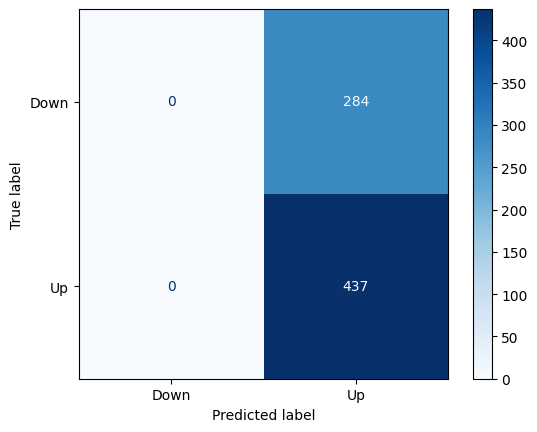

In [98]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_prob = []
my_model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        outputs = my_model(x).squeeze()
        y_prob.extend(outputs.cpu().numpy())

y_prob = np.array(y_prob)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_data_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_data_test, y_pred))